In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn
import mpld3
import pandas as pd
import numpy as np
import imp
from mpl_toolkits.basemap import Basemap
import mplleaflet

sn.set_context('talk')

# ECOREG full analysis (part 1: introduction and dimensionality reduction)

If possible, we'd like to get a paper from the ECOREG data, but I'm struggling to make time due to other commitments. The aim of this notebook is to set things out in a more structured way, which will hopefully make it easier to produce a draft manuscript if I get the chance.

## 1. Background and hypotheses

We are interested in understanding the relationships between in-stream ecology (as represented by various PB and MZB metrics), water chemistry and hydromorphology, especially the degree to which hydromorphologic alteration does or does not influence ecology. We know that short-term hydrological fluctuations (droughts, floods etc.) have a direct impact on species composition and abundances, but here we are more interested in long-term changes in ecological assemblages driven by modifications to the hydrological regime. The main questions we would like to address are:

 1. Is there a difference in ecology between regulated and unregulated streams? <br><br>
 2. Are there differences in water chemistry and hydromorphology between regulated and unregulated streams? <br><br>
 3. If the answers to (1) and (2) are "yes", can the differences in water chemistry and hydromorphology explain differences in ecology?

In reality, we do not expect to find straightforward answers to these questions. The ecological and water chemistry datasets available in this study represent a single point in time, rather than the long-term average conditions in each stream. It may therefore be difficult or impossible to link these "snap-shots" of water chemistry and ecology to the long-term hydrological regime, especially because we know the ecological assemblages will be most affected by recent hydrological extremes. Furthermore, even dividing our data into simple classes such as "regulated" or "unregulated" is problematic, because our sites exhibit various degrees of regulation from "almost natural" to "heavily modified". With this in mind, it seems likely that some of the "regulated" sites might be indistinguishable from, for example, natural systems downstream of large lakes. Finally, there are significant issues of spatial and temporal scale when it comes to relating catchment scale hydromorphological indices to plot scale ecology and water chemistry metrics: the ecology and water chemistry measurements were all collected in the field at the same time and place, whereas the hydrological indicators (HIs) are estimated by aggregating catchment scale flow records for the preceding several years. For this reason alone, we might expect to find stronger statistical relationships between ecology and water chemistry than between ecology and any of the HIs.

## 2. Literature

I haven't studied anything biological since I was 16. This section summarises some results and ideas from the literature that might be useful.

There are many papers that tackle the question of defining ecologically sustainable flows for regulated river reaches (e.g. [Gorla & Perona, 2013](http://www.sciencedirect.com/science/article/pii/S0022169413001662); [Vogel et al., 2007](http://onlinelibrary.wiley.com/doi/10.1029/2006WR005226/abstract;jsessionid=956B6BFE3355E4823370741FC2D21EF9.f02t02); [Zhang et al., 2015](http://www.sciencedirect.com/science/article/pii/S0022169415006812)). However, the vast majority of those using catchment scale hydrological data consider the effects on ecology *implicitly*, by assuming that changes in the flow regime can be used as a direct proxy for ecological impact. In other words, they calculate a statistical measure of how much the hydrology has changed, and then assume this is proportional to effects on the ecology. Based on my (admittedly limited) literature search, very few authors have managed to link their hydrological indicators to real ecology data in a convincing way. This must have been attempted (lots of times?) and [Richter et al. (1997)](http://onlinelibrary.wiley.com/doi/10.1046/j.1365-2427.1997.00153.x/abstract) present a good scientific argument as to why we should expect such a relationship to exist. However, I've yet to find a clear statistical demonstration of this in the literature without resorting to repeatedly sub-dividing the data, for example by estimating a wide range of different "structure indices" (e.g. [Lorenz et al., 2004](http://link.springer.com/article/10.1023%2FB%3AHYDR.0000025261.79761.b3)), which ultimately seems a bit arbitrary, and in any case would be impossible in our study without gathering more data regarding catchment properties. 

### 2.1. Indices of hydromorphological change

By far the most widely used metrics for assessing hydromorphological change are the Indicators of Hydrological Alteration (IHA) first proposed by [Richter et al. (1996)](http://onlinelibrary.wiley.com/doi/10.1046/j.1523-1739.1996.10041163.x/abstract). The authors define 32 metrics in five classes:

 * Magnitude of monthly water conditions
 * Magnitude and duration of annual extreme water conditions
 * Timing of annual extreme water conditions
 * Frequency and duration of high and low pulses
 * Rate and frequency of water condition changes
 
These 32 parameters can either be used to assess hydromorphological change at a single location, by considering changes before and after some intervention (such as building a dam), or they can be used to compare the hydrological regimes between different sites. Most of the studies I have found focusing on hydrological alteration have taken the former approach, using a "before-after" (BA) design, where flow data collected prior to alteration are compared to measurements taken afterwards (e.g. [Richter et al., 1997](http://onlinelibrary.wiley.com/doi/10.1046/j.1365-2427.1997.00153.x/abstract); [Vogel et al., 2007](http://onlinelibrary.wiley.com/doi/10.1029/2006WR005226/abstract)). In our study, we do not have any data prior to alteration, but we do have an approximate "control-impact" (CI) design for the Norwegian sites: as far as possible, Susi attempted to pair regulated sites with unregulated ones that have otherwise similar characteristics. I'm not sure if this is also the case for the German sites? (It looks unlikely from the map - see below - but **check this**). [Penas et al. (2016)](http://www.sciencedirect.com/science/article/pii/S1470160X15004069) reviewed the statistical power and advantages/disadvantages of different experimental design strategies in the context of assessing hydromorphological alteration. Their (rather obvious) conclusion is that "before-after-control-impact" (BACI) designs are the best, as these provide ways of estimating both spatially and temporally variable confounding factors. In comparison, BA designs are limited because they are not able to detect changes due to natural variability (i.e. the before and after periods are not expected to be the same, regardless of alteration), whereas CI designs are limited because there are no true analogues for the sites (i.e. we assume that a neighbouring unmodified site reflects what the impacted location would have looked like without alteration, which involves some big assumptions regarding site similarity). Note that the approximate CI design of our study therefore places additional constraints on what we can expect to identify statistically.

The IHA metrics are very widely used, but numerous other systems have also been proposed. [Olden & Poff (2003)](http://onlinelibrary.wiley.com/doi/10.1002/rra.700/abstract) considered around 170 hydrological metrics applied to more than 400 streams across the USA, demonstrating that the 32 IHA parameters did a reasonable job of representing the overall variability across the wider group of 170. However, they also identified considerable redundancy even within the IHA metrics, suggesting that dimensionality reduction techniques (see below) should be used to define a subset of hydrological parameters for any given analysis. 

A popular alternative to the IHA approach is the eco-surplus/deficit method proposed by [Vogel et al. (2007)](http://onlinelibrary.wiley.com/doi/10.1029/2006WR005226/abstract;jsessionid=956B6BFE3355E4823370741FC2D21EF9.f02t02). This provides a means of summarising hydrological changes in just a small number of simple metrics, rather than using 32 indicators as required by the IHA methodology. [Gao et al. (2009)](http://www.sciencedirect.com/science/article/pii/S0022169409003321) have shown that the eco-surplus/deficit approach generally does a good job of encoding the information captured by the broader suite of IHA metrics. This approach is therefore appealing, as it would dramatically simplify our analysis and would also avoid issues of collinearity in our statistical tests. Unfortunately, Vogel's method is only really suitable for a BA experimental design, which will not work with our data. Nevertheless, the basic idea of summarising hydrological regimes using flow duration curves is an interesting one, and something that may be worth exploring further when testing hypothesis 2 (see section 1).

Most hydrological indicators are designed to be used with long-term monitoring records: a number of authors state that 20 years is the usual rule of thumb to ensure stable estimates of streamflow predictability ([Richter et al., 1996](http://onlinelibrary.wiley.com/doi/10.1046/j.1523-1739.1996.10041163.x/abstract); [Olden & Poff, 2003](http://onlinelibrary.wiley.com/doi/10.1002/rra.700/abstract); Gan et al., 1991). In our dataset, we have only three years of flow data prior to ecological sampling at each site, which precludes using the full suite of IHA metrics as originally proposed by [Richter et al. (1996)](http://onlinelibrary.wiley.com/doi/10.1046/j.1523-1739.1996.10041163.x/abstract). However, given that we have ecological data for only a single time point, I do not think this will be a major limitation - linking multi-year hydrological averages to a single round of ecological sampling is likely to be difficult regardless.

### 2.2. Linking hydrology and ecology

A few previous studies have attempted to link the IHA metrics to plot scale ecological data. [Monk et al. (2007)](http://onlinelibrary.wiley.com/doi/10.1002/rra.964/abstract) related a large number of HIs to LIFE scores at 83 locations in England and Wales, using long-term data for both metrics (20 years for hydrology and 11 years for ecology). Unfortunately, their paper does not present the relationships identified very clearly and it also uses stepwise linear regression, which means the p-values and significance tests presented are likely to be inaccurate (see e.g. [here](http://www.lexjansen.com/pnwsug/2008/DavidCassell-StoppingStepwise.pdf)). [Yang et al. (2008)](http://onlinelibrary.wiley.com/doi/10.1029/2006WR005764/abstract) used genetic programming to relate an ecological time series (annual Shannon Index of fish species diversity) from a river in Illinois to annual hydrograph summaries calculated using the IHA method. Their study is similar to ours in that the authors did not identify a time at which hydrological modification took place - they simply looked for relationships between ecological and hydrological metrics. However, a key difference is that Yang et al. had access to a long (34 year) time series of ecological data to match the hydrological measurements. In contrast, we have just a single sampling point for ecology, but our analysis is spatially (rather than temporally) distributed across 40 different sites.

More recently, [Zhang et al. (2015)](http://www.sciencedirect.com/science/article/pii/S0022169415006812) have applied the eco-surplus/deficit concept first proposed by [Vogel et al. (2007)](http://onlinelibrary.wiley.com/doi/10.1029/2006WR005226/abstract;jsessionid=956B6BFE3355E4823370741FC2D21EF9.f02t02) in a BA study focusing on four sites in China. They demonstrated correlations between their estimated degrees of hydrologic alteration and changes in the Shannon Diversity Index (an entropy-based ecological metric), but they don't say diversity of what - algae, macroinvertebrates, fish? Their study has the advantage of having before and after ecological data for multiple years, which dramatically increases their ability to detect changes compared to our dataset. Nevertheless, the relationships identified are not clear and their interpretation seems slightly bizarre e.g. their description of *Fig. 7* on page 720 makes me think they must be looking at a different plot to me!

### 2.3. Implications

My overall impression, based upon statistical considerations and a brief look at the literature, is that we cannot reasonably expect to demonstrate a clear link between HIs and ecological metrics, given the data we have available. My preliminary analysis of the ECOREG data (supported by Susi's more detailed work on the Norwegian dataset?) identified a small number of weak but significant relationships between ecology and water chemistry, but nothing of interest between ecology and hydrology. Given the considerations above this is perhaps not surprising, and I'd be wary of concluding that water chemistry has a greater influence on ecological assemblages than hydrology - it seems just as likely that the result is due to limitations in our dataset.

## 3. Methodology

### 3.1. Sampling sites

Our dataset comprises 65 sites in total, of which approximately half (33) are considered "regulated", but with a considerable gradient from "almost natural" to "substantially modified" (**is this correct - are any of them heavily modified?**). 25 of the sites are located in Germany (13 regulated) and the remaining 40 are in Norway (20 regulated). See maps below.

In [2]:
# Read basic datasets

# Hydro indicators
in_xls = r'C:\Data\James_Work\Staff\Susi_S\ECOREG\Stats_Input_Data\hydro_indic.xlsx'
hi_df = pd.read_excel(in_xls, sheetname='hydro_indic', index_col=0)

# Site props
in_xls = r'C:\Data\James_Work\Staff\Susi_S\ECOREG\Stats_Input_Data\site_props.xlsx'
site_df = pd.read_excel(in_xls, sheetname='site_props', index_col=0)

# MZB
in_xls = r'C:\Data\James_Work\Staff\Susi_S\ECOREG\Stats_Input_Data\mzb_chem_ecol.xlsx'
mzb_df = pd.read_excel(in_xls, sheetname='mzb_data', index_col=0)

# PB
in_xls = r'C:\Data\James_Work\Staff\Susi_S\ECOREG\Stats_Input_Data\pb_chem_ecol.xlsx'
pb_df = pd.read_excel(in_xls, sheetname='pb_data', index_col=0)

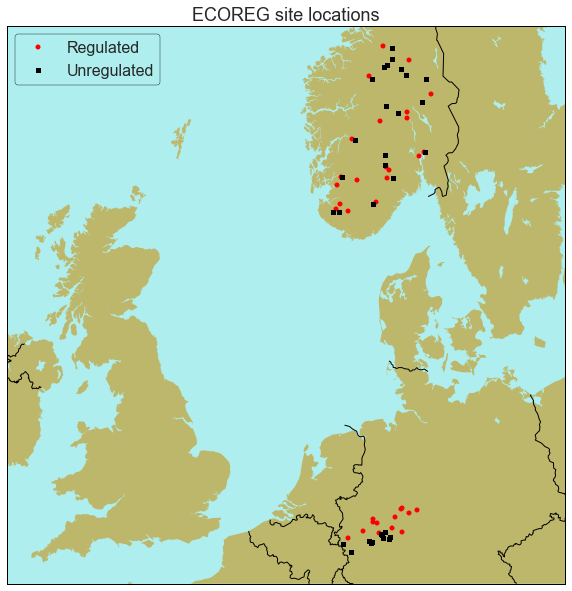

In [3]:
# Map
# Map of sites
fig = plt.figure(figsize=(10, 10))

# Use Albers Equal Area projection
m = Basemap(projection='aea',
            width=1500000,
            height=1500000,
            resolution='i',
            lat_1=46.5,          # 1st standard parallel
            lat_2=66.5,          # 2st standard parallel
            lon_0=4,lat_0=56.5)  # Central point

# Add map components
m.fillcontinents (color='darkkhaki', lake_color='paleturquoise')
m.drawcountries(linewidth=1)
m.drawmapboundary(fill_color='paleturquoise')

# Map (long, lat) to (x, y) for plotting
x, y = m(site_df['lon'].values, site_df['lat'].values)

# Add to df
site_df['east'] = x
site_df['north'] = y

# Get reg and unreg
reg_df = site_df.query('regulated == 1')
ureg_df = site_df.query('regulated == 0')

# Plot
plt.plot(reg_df['east'], reg_df['north'], 'or', markersize=5, label='Regulated')
plt.plot(ureg_df['east'], ureg_df['north'], 'sk', markersize=5, label='Unregulated')
plt.title('ECOREG site locations', fontsize=18)
l = plt.legend(loc='upper left', fontsize=16, 
               frameon=True, fancybox=True)
l.get_frame().set_facecolor('paleturquoise')
l.get_frame().set_edgecolor('k')

In [4]:
# Interactive map - may be useful for exploring site properties?
fig = plt.figure(figsize=(10, 10))
plt.plot(reg_df['lon'], reg_df['lat'], 'or', markersize=15, label='Regulated')
plt.plot(ureg_df['lon'], ureg_df['lat'], 'sk', markersize=15, label='Unregulated')

mplleaflet.display()

### 3.2. Water chemistry and ecology datasets

All 65 sites have been surveyed for PB, and 61 of the 65 have approximately contemporaneous MZB data as well. In Norway, all ecological surveys (for both PB and MZB) took place during September 2013, but the sampling dates in Germany were more variable (**add details?**). For PB, the metrics measured were species **richness** and **abundance**, both for the overall assemblage and subdivided according to red algae, green algae and cyanobacteria. For MZB, a wide variety of metrics were calculated using the [ASTERICS software package](http://www.asterics.de/en/download/berechnung/) (version 4; **reference?**):

 * Abundance [ind/m2]
 * Number of Taxa
 * German Saprobic Index (new version)
 * Average score per Taxon
 * Diversity (Shannon-Wiener-Index)
 * Evenness
 * Grazers and scrapers [%]
 * Miners [%]
 * Xylophagous Taxa [%]
 * Shredders [%]
 * Gatherers/Collectors [%]
 * Active filter feeders [%]
 * Passive filter feeders [%]
 * Predators [%]
 * Parasites [%]
 * Swimming/skating [%]
 * Swimming/diving [%]
 * Burrowing/boring [%]
 * Sprawling/walking [%]
 * (Semi)sessile [%]
 * EPT-Taxa [%]
 * Number of Genera
 * Life Index

The ecological metrics were standardised to adjust for differences in the survey strategies used in Germany and Norway (**more detail needed**).

During each field visit, water samples were collected at each survey location and analysed for total nitrogen (TN), total phosphorus (TP) and total organic carbon (TOC). In-situ measurements of pH and conductivity were also taken using a hand-held probe.

### 3.3. Hydrological data

Sites were selected to be coincident with flow gauging stations, such that daily average flow data are available for all 65 locations. Long discharge datasets are available for some stations, but many of the older datasets have problems with missing data in the early parts of the series. Each site has at least three years' worth of daily flow data spanning the period immediately prior to ecological sampling. 

The raw data series were processed to generate 62 hydrological parameters, closely based on the IHA metrics defined by [Richter et al. (1996)](http://onlinelibrary.wiley.com/doi/10.1046/j.1523-1739.1996.10041163.x/abstract). The IHA software for calculating these metrics was not used, however, as for this study a single set of metrics based on the three year period prior to sampling was desired for each site, rather than splitting the data according to e.g. water or calendar years as implemented by the [IHA R package](https://github.com/jasonelaw/iha). Small gaps in the daily flow series (up to 7 days in length) were filled using linear interpolation prior to calculating the metrics. 

For a more detailed description of the hydrological indices used, see [here](http://nbviewer.jupyter.org/github/JamesSample/ECOREG/blob/master/hydro_indicators_diy.ipynb). 

## 4. Statistical analysis

(This section will eventually need separating into "Methods" and "Results", but for now it's easier to treat them together).

### 4.1. Catchment typologies

Germany and Norway have very different hydrological, ecological and climatic regimes. In particular, hydrological responses in Norwegian streams are expected to be more heavily influenced by snow melting processes during the late spring and early summer. The image below illustrates a typical hydrological year in each country, by plotting the mean flow in each month with a 95% CI representing the variability among sites in each country. Values are plotted as a percentage of the long-term annual mean in order to allow for differences in catchment size.



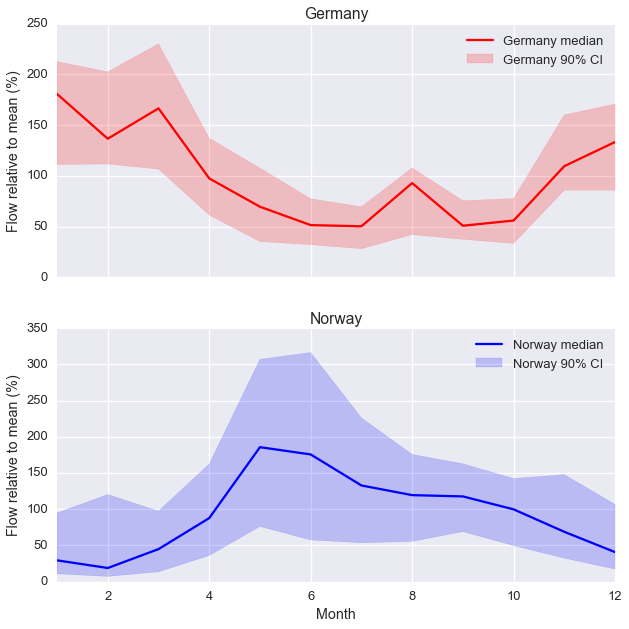

In [5]:
# Extract data of interest
df = hi_df.query('(eco_dataset=="pb") & (time_per==3)')

# Extract cols of interest
cols = ['avg%02d' % mon for mon in range(1, 13)] + ['mean',]
df = df[cols]

# Calculate monthly as % of long-term mean
for col in df.columns:
    df[col] = 100.* df[col] / df['mean']

del df['mean']
    
# Join country 
df = df.join(site_df['country'])

# Calc ststs.
grpd = df.groupby('country')
df = grpd.describe(percentiles=[0.05, 0.50, 0.95])

# Plot
fig, axes = plt.subplots(nrows=2, ncols=1, 
                         sharex=True, figsize=(10, 10))

# Germany
axes[0].fill_between(range(1, 13), 
                     df.loc['D', '5%'].values,
                     df.loc['D', '95%'].values,
                     color='r', alpha=0.2, 
                     label='Germany 90% CI')
axes[0].plot(range(1, 13), 
             df.loc['D', '50%'].values,
             'r-', label='Germany median')

axes[0].set_ylabel('Flow relative to mean (%)')
axes[0].set_title('Germany')
axes[0].legend(loc='best')

# Norway
axes[1].fill_between(range(1, 13), 
                     df.loc['N', '5%'].values,
                     df.loc['N', '95%'].values,
                     color='b', alpha=0.2, 
                     label='Norway 90% CI')
axes[1].plot(range(1, 13), 
             df.loc['N', '50%'].values,
             'b-', label='Norway median')

axes[1].set_ylabel('Flow relative to mean (%)')
axes[1].set_title('Norway')
axes[1].legend(loc='best')

plt.xlim((1, 12))
plt.xlabel('Month')

As expected, the differences are very stark: the German sites have high autumn and winter flows, which generally decline throughout the summer, whereas Norwegian sites have very low flows during the winter, with peak discharges due to snow melting events during May and June. The sudden increase in flows in Germany during August is a little strange - **perhaps investigate further**?

Given the differences in hydrology and climate, it should be no surprise that there are also substantial differences in ecology and water chemistry. In this study we are not specifically interested in characterising the hydro-climatic contrasts between Germany and Norway - our focus is instead on the effects of hydromorphologic alteration on ecology and water chemistry. Based on the plots above (and my earlier preliminary analysis), if we treat the sites from Germany and Norway as a single dataset, I suspect most of our findings will relate to differences due to geography, rather than due to river regulation. To allow for this, I propose analysing the data separately for each country - essentially defining German and Norwegian catchment "typologies", which are not expected to behave in the same way. This approach is consistent with previous work. In particular, [Olden & Poff (2003)](http://onlinelibrary.wiley.com/doi/10.1002/rra.700/abstract) divided their data according to 6 catchment typologies, and found that streams dominated by snow melt processes (as in Norway) generally responded differently to other categories and required the use of different sets of representative HIs. Similarly, [Monk et al. (2007)](http://onlinelibrary.wiley.com/doi/10.1002/rra.964/abstract) used hydrological regime classification to group their sites prior to analysis.

### 4.2. Dimensionality reduction

The raw dataset consists of more than 100 variables in total: 62 HIs, 23 MZB metrics, 8 PB metrics, 5 water chemistry variables and two geographic co-ordinates (latitude and longitude). We also have categorical variables specifying the country (`N`, or `D`) and whether a river is regulated or not. The number of possible relationship combinations to test is therefore large and, because many of the variables are similar in nature and meaning (e.g. there are several diversity-based ecological indices), it seems likely that **collinearity** will be a problem for any statistical tests. The first step in the analysis is therefore to reduce the number of metrics to a more manageable subset using a combination of **domain knowledge** and **dimensionality reduction** techniques.

Principal Component Analysis (PCA) is a popular (linear) technique for dimensionality reduction and [Olden & Poff (2003)](http://onlinelibrary.wiley.com/doi/10.1002/rra.700/abstract) suggested it offers pragmatic variable selection in the context of eco-hydrological data analysis: 

> *Such an approach may be particularly useful in large-scale, data-intensive studies where indices other than hydrologic indices are being examined and related to patterns in biological data*. 

In the following sections, I've used PCA to identify metrics for further analysis and to identify some potentially interesting patterns. 

The principal components (PCs) in a PCA are linear combinations of the original variables, which can make them difficult to interpret in a physically meaningful way. As far as possible, I'd like to continue working with a subset of the original, "raw" metrics, rather than a reprojection of them into an arbitrary sub-space. I have therefore followed the approach of [Gao et al. (2009)](http://www.sciencedirect.com/science/article/pii/S0022169409003321) by choosing the metric with the highest (absolute) loading to represent each PC (see below for details). Because the PCs are orthogonal, choosing one metric from each of the first few PCs should reduce correlation and avoid problems with collinearity.

The remainder of this notebook consists of PCA analyses for PB, MZB, water chemistry and HIs, all performed separately for Germany and Norway. This creates a lot of plots, so to keep things manageable I've tried to follow a consistent format throughout. For each dataset (PB, MZB, water chenistry and HIs), I've done the following:

 1. Summarise previous observations based on earlier analyses. These comments mostly relate to differences identified between Germany and Norway, which provide context for the split analysis presented here. <br><br>
 
 2. For each country:
 
    a. Screen for data anomalies. PCA is strongly affected by outliers, so it's a good idea to investigate any possible data issues before calculating the PCs.
    
    b. Perform the PCA. 
    
    c. Following [Gao et al. (2009)](http://www.sciencedirect.com/science/article/pii/S0022169409003321), use the [Kaiser-Guttman Criterion (KGC)](https://en.wikipedia.org/wiki/Factor_analysis#Criteria_for_determining_the_number_of_factors) to determine the number of principal components to keep. This amounts to keeping those components with eigenvalues greater than 1. The method is rather arbitrary and has been criticised, but for the work presented here it provides a simple and consistent method for selecting the number of PCs. In all the cases below, the KGC selects enough PCs to explain around 80 - 90% of the overall variance, which seems reasonable to me.
    
    d. Look at plots showing the data projected into the space defined by the first 2 and 3 PCs. Consider the loadings on these PCs to see if they are suggestive of particular groups of indices (e.g. "*PC1 is mainly winter and spring high flows.*"). If possible, interpret the distribution of the data in terms of river regulation. 
    
    e. For each of the PCs selected by the KGC, choose the metric with the highest absolute loading to represent that PC. These are the metrics that will be considered in subsequent analyses.

To keep things tidy, I've defined a convenience function for the PCA and then shifted it into a separate Python file (available [here](https://github.com/JamesSample/ECOREG/blob/master/ecoreg_code.py)). This code is imported into this notebook below, providing a consistent interface for the PCA and (hopefully) keeping this notebook more manageable.

In [6]:
# Import custom functions
func_path = r'C:\Data\James_Work\Staff\Susi_S\ECOREG\Python\ECOREG\ecoreg_code.py'

ecoreg = imp.load_source('ecoreg_code', func_path)

#### 4.2.1. PB data

##### Overview

Previous work in section 2.2 of [this notebook](http://nbviewer.jupyter.org/github/JamesSample/ECOREG/blob/master/ecoreg_prelim_analysis.ipynb) compared PB distributions in Norway and Germany. In general, the patterns for abundance and richness are very similar: the species richness and abundance of green algae and cyanobacteria in Norway are greater than in Germany, whereas the abundance and richness of red algae is broadly similar in both locations. As a result, overall richness and abundance is also greater in Norway than in Germany. 

The "overall" scores therefore do a reasonable job of representing the main patterns in the underlying green algae and cyanobacteria data. With this in mind, it seems reasonable to represent the PB data using (i) one of the overall scores and (ii) one of the red algage metrics. The abundance scores were originally evaluated on a qualitative scale, which perhaps makes them less reliable than the richness scores (?). For this reason, I'm tempted to use **overall PB richness** and **red algae richness** as the two primary indicators of PB response in this analysis. Let's see if this also looks reasonable based on PCA.

##### Germany

Variance explained by first 3 PCs (%):

[ 47.8655807   22.16156081  13.19290031]

Total: 83.22%


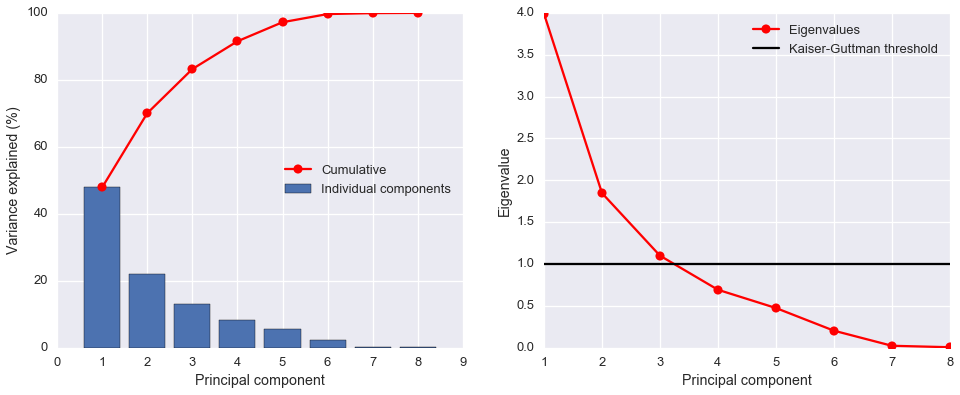

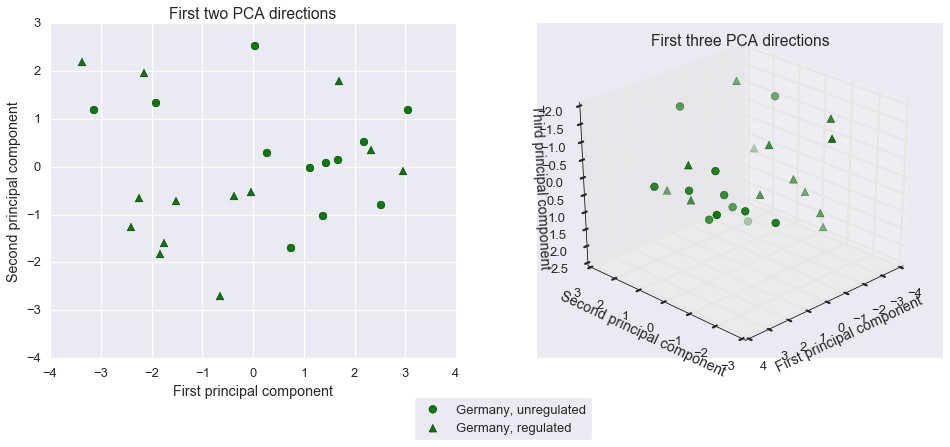

,1,2,3,4,5,6,7,8
pb_rich,-0.468368,-0.075450,0.192470,-0.365488,0.172611,-0.019488,0.562352,0.507837
green_rich,-0.154014,-0.609305,0.337257,-0.374134,0.151866,0.349557,-0.382802,-0.243962
cyano_rich,-0.424705,0.225678,-0.195859,-0.260221,0.391586,-0.562819,-0.225149,-0.376594
red_rich,-0.332611,0.284598,0.353562,-0.184381,-0.780129,-0.067086,-0.091932,-0.166788
pb_abund,-0.443293,-0.186695,-0.180382,0.444603,-0.030074,0.265881,0.443923,-0.519386
green_abund,-0.176566,-0.619854,-0.242132,0.250270,-0.319658,-0.497615,-0.167733,0.292244
cyano_abund,-0.364278,0.191951,-0.590233,-0.094231,-0.083330,0.486862,-0.369436,0.304532
red_abund,-0.324845,0.187642,0.496292,0.596275,0.274174,0.028572,-0.341166,0.255018


In [7]:
# Join categorical variables to PB data
df = pb_df.join(site_df[['country', 'regulated']])

# Select country
df = df.query('country == "D"')

# Columns to consider
pb_cols = ['pb_rich', 'green_rich', 'cyano_rich', 'red_rich', 
           'pb_abund', 'green_abund', 'cyano_abund', 'red_abund']

# Run PCA
res = ecoreg.run_pca(df, cols=pb_cols)
res

The plot of the first two PCs suggests that there may be significant differences in PB assemblages between regulated and unregulated sites in Germany: a simple linear separator at $PC1 \approx 0$ does a pretty good job of dividing the two categories. **This is investigated in more detail later**. Looking at the loadings, PC1 is mostly inversely correlated with overall PB richness and abundance, so the plot suggests that, in general, **regulated sites have greater PB abundance and richness**. This seems reasonable, as we might expect regulated sites to have more stable flow conditions than unregulated ones, potentially reducing the number of scouring and drying-out events and allowing PB communities to develop more fully.

The KGC implies keeping the first 3 PCs. The highest absolute loading on PC1 is **overall PB richness**, for PC2 it's **green algae abundance** and for PC3 it's **cyanobacteria abundance**.

##### Norway

Variance explained by first 3 PCs (%):

[ 61.58332351  17.04691049  16.20821227]

Total: 94.84%


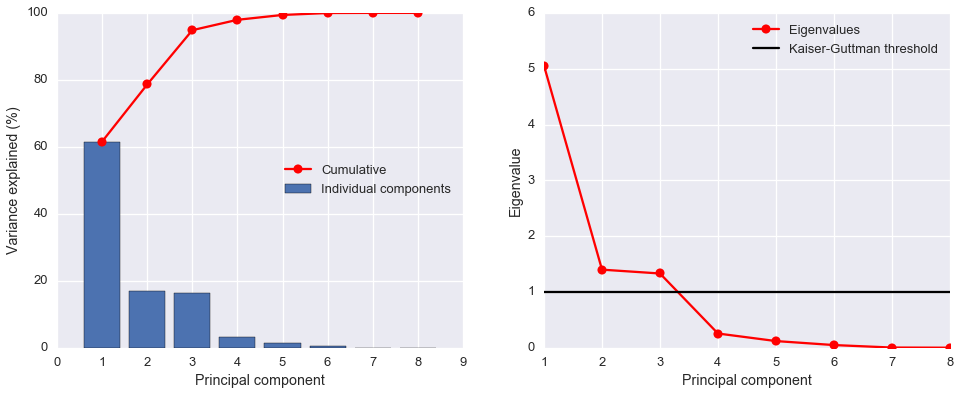

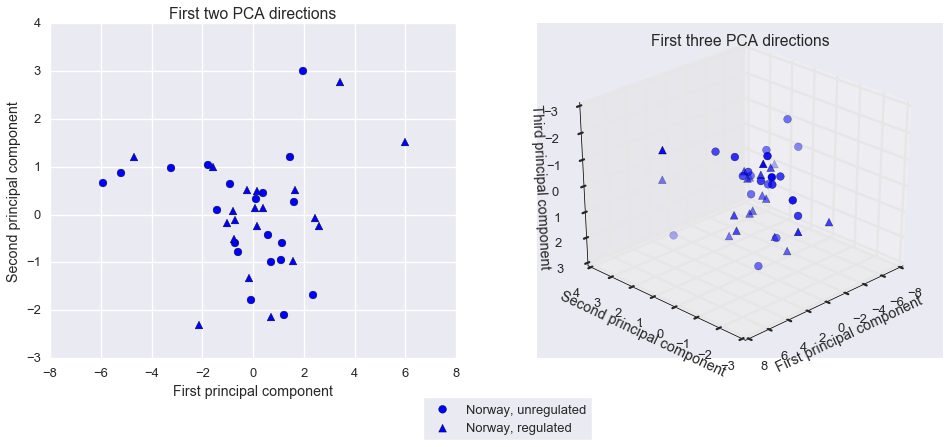

,1,2,3,4,5,6,7,8
pb_rich,0.433529,-0.065927,0.104958,-0.461769,0.009239,-0.027719,-0.564551,-0.513701
green_rich,0.358940,-0.442501,0.148385,-0.441402,-0.419547,0.106534,0.392593,0.342057
cyano_rich,0.332540,0.493375,0.210084,-0.294316,0.615415,0.093263,0.272980,0.230844
red_rich,0.313121,0.131720,-0.601687,-0.039169,-0.057863,-0.707219,0.099245,0.087675
pb_abund,0.428939,-0.088527,0.154789,0.453416,0.018465,0.012646,-0.513187,0.561040
green_abund,0.352080,-0.475054,0.113645,0.442309,0.366372,-0.082903,0.366456,-0.407944
cyano_abund,0.276072,0.537365,0.366241,0.295827,-0.547688,-0.064157,0.205330,-0.259113
red_abund,0.300703,0.129627,-0.624336,0.122638,-0.085325,0.684015,0.054530,-0.099037


In [8]:
# Join categorical variables to PB data
df = pb_df.join(site_df[['country', 'regulated']])

# Select country
df = df.query('country == "N"')

# Columns to consider
pb_cols = ['pb_rich', 'green_rich', 'cyano_rich', 'red_rich', 
           'pb_abund', 'green_abund', 'cyano_abund', 'red_abund']

# Run PCA
res = ecoreg.run_pca(df, cols=pb_cols)
res

As above, the KGC implies keeping the first three PCs, which in this case account for nearly 95% of the overall data variance. Once again, the first PC is dominated by **overall PB richness and abundance**, while PC2 is predominantly correlated with the **cyanobacteria metrics** and PC3 is mostly related **red algae**. Unlike Germany, there is no clear separation visible between the regulated and unregulated sites in Norway.

##### PB summary

 * There is some evidence for differences in PB assemblages between regulated and unregulated sites in Germany, but not in Norway. It remains to be seen whether the German differences are significant. <br><br>
 
 * The loadings are usually very similar between the richness and abundance metrics for each PB class. Because I have more faith in the data quality of the richness measurements, I will choose **richness** as the metric for further investigation where possible, even if the abundance loadings in marginally greater in the PCA results. This does not apply for cyanobacteria on PC3 in Germany, because the absolute value of the richness score is significantly smaller than that for abundance. <br><br>
 
 * The selected metrics for further analysis for PB are:
 
| **PC** |         **Germany**         |        **Norway**         |
|:--:|:-----------------------:|:----------------------:|
|  1 |   Overall PB richness   |   Overall PB richness  |
|  2 |   Green algae richness  | Cyanobacteria richness |
|  3 | Cyanobacteria abundance |   Red algae richness   |

#### 4.2.2. MZB data

##### Overview

The MZB dataset is more complicated than for PB, with many more possible variables to consider. The various indicators (listed in section 3.2 above) can be divided into three broad categories: metrics describing mode of life (swimming, burrowing etc.); metrics describing feeding behaviour (miners, filter-feeders etc.); and overall ecological summaries such as the LIFE Index or the Shannon-Wiener Diversity. In general, my preference is to include the overall metrics if possible, rather than focusing on just a small subset of behaviours or modes of life. Previous exploratory analysis (section 2.1 of [this notebook](http://nbviewer.jupyter.org/github/JamesSample/ECOREG/blob/master/ecoreg_prelim_analysis.ipynb)) compared differences between the scores for Germany and Norway and the patterns identified included:

 1. Norway has fewer burrowing/boring taxa than Germany. <br><br>
 
 2. German sites generally have few parasites or miners, whereas the Norwegian sites are more variable. <br><br>
 
 3. Shredders and xylophages are rare in Norway, but occur in Germany. <br><br>
 
 4. When it comes to filter-feeding, German streams are dominated by passive taxa, whereas the opposite is true in Norway. <br><br>

 5. There is a strong positive correlation between miners and active filter feeders, but the relationship does not extend to passive filter feeders. Miners are also strongly correlated with parasites, perhaps because some miners are parasites? <br><br>
 
 6. There is a positive relationship between parasites and active filter-feeders, suggesting that active filter feeders are commonly parasitised? <br><br>
 
 7. Most German and Norwegian sites have similar overall abundances, but the histogram for Norway is strongly skewed, indicating that a few of the Norwegian sites have very high abundance indeed. <br><br>
 
 8. German sites tend to have a larger number of taxa and genera i.e. more diversity (and also greater "evenness", whatever that means). Both countries have very similar distributions of EPT taxa, but the LIFE index for the Norwegian streams is much more variable than for the sites in Germany, albeit with approximately the same overall mean.
 
##### Germany (all MZB metrics)

**Note:** The code below produces a warning: *ComplexWarning: Casting complex values to real discards the imaginary part*. This appears to be due to very small numerical errors in the solutions for the eigenvalues and eigenvectors from the matrix calculations. The result is that some of the smaller components have very tiny complex parts (e.g. $1.10^{−15}$i). This warning can be ignored.

Variance explained by first 7 PCs (%):

[ 28.5685183   20.2433337   12.27163791   8.41029392   7.18117162
   6.18561239   4.3459611 ]

Total: 87.21%


C:\Data\WinPython-64bit-2.7.10.3\python-2.7.10.amd64\lib\site-packages\numpy\core\numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


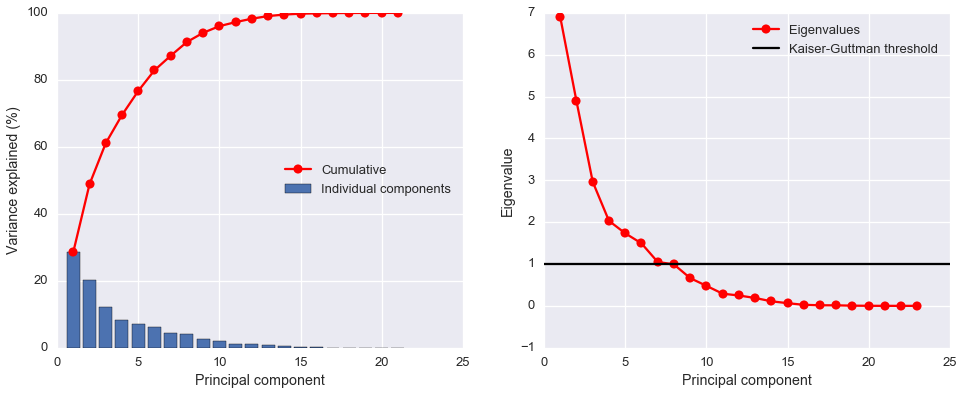

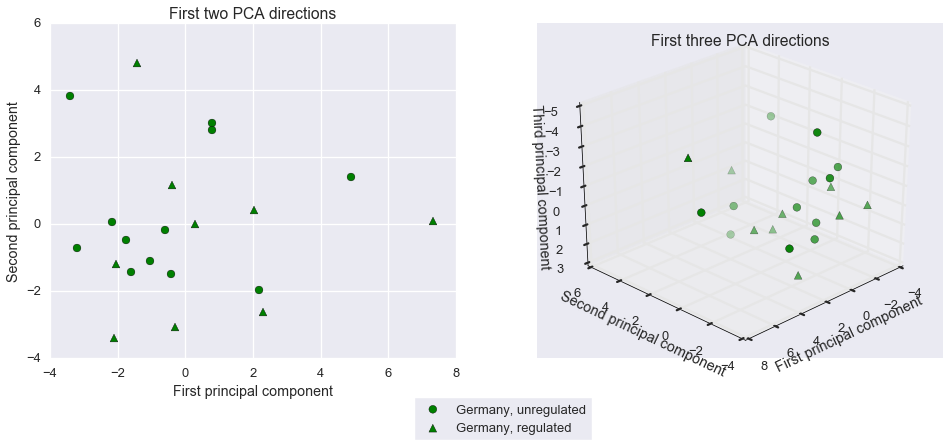

,1,2,3,4,5,6,7,8,9,10,...,12,13,14,15,16,17,18,19,20,21
abund,-0.175231,0.238476,-0.312078,0.053476,-0.095248,-0.182313,-0.009315,0.330092,-0.212062,0.008734,...,0.235539,-0.271127,-0.029926,0.000651,-0.281400,0.389320,0.311593,0.174496,-0.028204,-0.091132
n_taxa,-0.329255,0.147572,-0.121359,0.025849,-0.002918,0.025365,0.161857,0.318070,-0.141953,0.006405,...,0.002844,0.073825,0.156727,0.043680,0.044777,-0.328036,-0.394708,0.044113,-0.334872,-0.401490
ger_sap_idx,0.148817,0.090775,0.431961,0.181827,0.230593,-0.057276,-0.117545,0.207920,-0.216020,-0.094398,...,0.215338,-0.214712,-0.239510,-0.416102,-0.171224,-0.187871,-0.118455,-0.335060,0.092680,0.043070
av_score_p_taxon,-0.217862,-0.146716,-0.345813,0.104102,-0.026373,0.140703,-0.128681,-0.060764,0.357871,-0.311424,...,0.421848,0.130780,-0.234707,-0.034027,0.066578,0.131550,0.065384,-0.288672,0.096862,-0.099669
shan_wei_idx,-0.321714,0.133558,0.075840,-0.198229,-0.013674,0.231260,0.178592,-0.024945,-0.074063,-0.195987,...,-0.068794,0.085085,0.046113,-0.074427,0.025129,0.059471,-0.131179,0.171041,-0.111852,0.547718
even,-0.221809,0.108226,0.196215,-0.301397,-0.051616,0.330371,0.127434,-0.263894,0.015661,-0.335643,...,-0.255359,-0.031480,-0.169803,-0.170480,-0.051552,0.051100,0.194537,-0.104934,0.066628,-0.371481
graz_scrap,-0.112653,-0.138395,-0.070286,-0.508288,0.113082,-0.347858,0.026940,-0.048450,-0.348054,0.256055,...,-0.143214,0.038898,-0.162294,0.010553,0.141965,0.315760,-0.118516,-0.281242,0.189017,-0.060572
miners,0.330167,0.042941,-0.230107,-0.015787,0.030648,0.251234,0.099908,0.058742,-0.072229,-0.033196,...,-0.095293,-0.235614,0.152193,-0.023039,0.285819,0.049875,-0.096632,-0.226538,-0.015620,-0.376016
xylo,-0.136678,-0.178314,-0.026882,0.301028,-0.131768,0.243450,-0.266720,-0.101287,-0.691492,-0.279511,...,-0.077173,-0.075361,-0.015904,0.232255,0.077649,-0.005980,0.045800,0.029782,0.101844,0.046448
shred,-0.243319,0.081457,-0.092712,0.415494,0.176589,0.094581,-0.264379,-0.111485,0.061676,0.262982,...,-0.309505,0.232099,-0.085561,-0.305777,-0.048277,0.388590,-0.306071,-0.064601,-0.120227,-0.034902


In [9]:
# Join categorical variables to MZB data
df = mzb_df.join(site_df[['country', 'regulated']])

# Select country
df = df.query('country == "D"')

# Columns to consider
mzb_cols = ['abund', 'n_taxa', 'ger_sap_idx', 'av_score_p_taxon', 
            'shan_wei_idx', 'even', 'graz_scrap', 'miners', 'xylo',
            'shred', 'gath_coll', 'acti_filt_feed', 'pass_filt_feed',
            'pred', 'para', 'swim_skat', 'swim_div', 'burr_bore', 
            'sprawl_walk', 'sessil', 'ept_taxa', 'n_genera', 'life_idx']

# Run PCA
res = ecoreg.run_pca(df, cols=mzb_cols)
res

The KGC implies keeping 7 PCs, which together explain about 87% of the variance. 

There is no clear distinction between regulated and unregulated sites on the plots in 2 and 3 dimensions.

The loadings table indicates that larger (more positive) values on PC1 correspond to fewer taxa and genera, but greater proportions of active filter feeders, parasites and miners. These results are entirely in agreement with the previous observations (see points 2, 4 and 8 in the list above).

The selected metrics based on the absolute loadings for each of the first seven PCs are given in the table at the end of this section. The chosen indicators are dominated by mode of life and feeding habit scores, rather than by overall metrics. I think it might be useful to consider a set of MZB indicators focusing on the "overall" metrics, such as LIFE scores or Shannon Diversity. 

##### Germany (overall MZB metrics only)

Variance explained by first 3 PCs (%):

[ 44.42038564  24.26816797  15.01319256]

Total: 83.70%


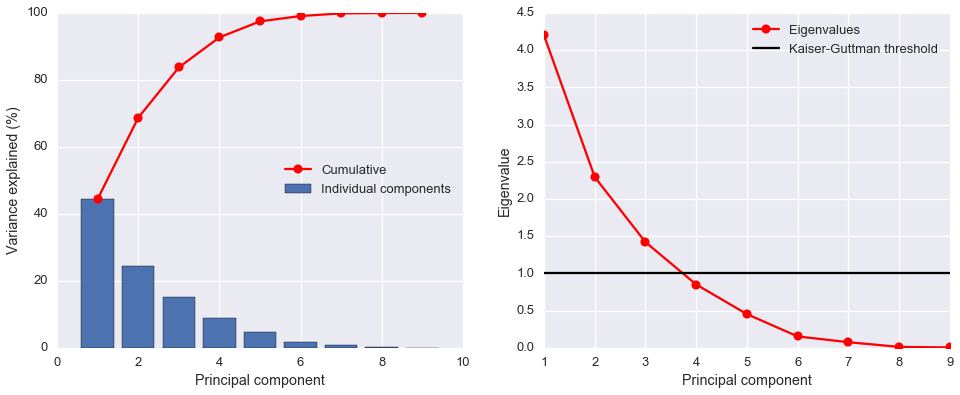

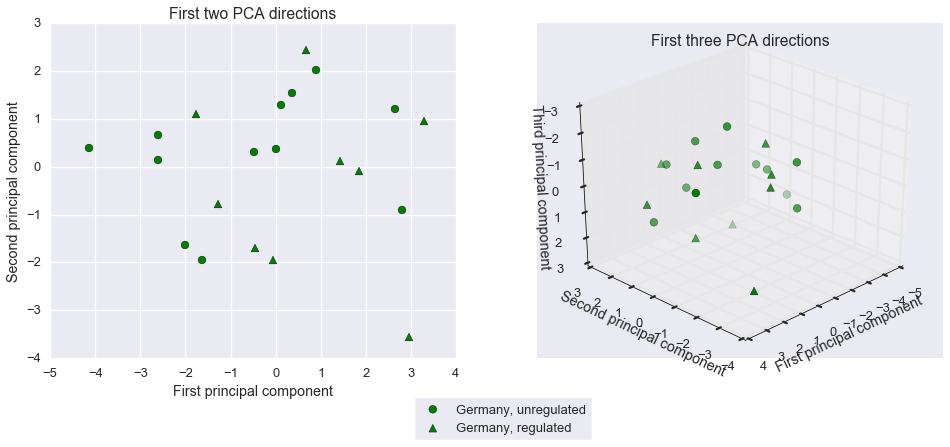

,1,2,3,4,5,6,7,8,9
abund,-0.360853,-0.029073,0.534165,-0.103507,-0.285916,0.432261,-0.549233,0.034393,0.038175
n_taxa,-0.467481,0.141035,0.122490,-0.225923,-0.103320,-0.154481,0.382126,0.443317,-0.564301
ger_sap_idx,0.297061,0.472251,0.137429,-0.276712,0.075212,0.632431,0.419835,-0.102618,0.029329
av_score_p_taxon,-0.311213,-0.369504,-0.130380,-0.105279,0.786732,0.338169,-0.023920,0.064190,-0.023078
shan_wei_idx,-0.412644,0.298768,-0.258625,0.181873,-0.075978,0.061660,0.129266,0.390937,0.679250
even,-0.260987,0.342726,-0.448384,0.476652,-0.059550,0.267329,-0.180388,-0.318495,-0.420938
ept_taxa,-0.030002,-0.223207,-0.609271,-0.630831,-0.371530,0.159094,-0.125321,-0.032513,0.003441
n_genera,-0.466067,0.111470,0.144694,-0.260922,0.049029,-0.281878,0.211554,-0.718273,0.196999
life_idx,-0.098182,-0.592232,0.060792,0.352547,-0.364987,0.308101,0.515539,-0.128028,0.036379


In [10]:
# Join categorical variables to MZB data
df = mzb_df.join(site_df[['country', 'regulated']])

# Select country
df = df.query('country == "D"')

# Columns to consider
mzb_cols = ['abund', 'n_taxa', 'ger_sap_idx', 'av_score_p_taxon', 
            'shan_wei_idx', 'even', 'ept_taxa', 'n_genera', 'life_idx']

# Run PCA
res = ecoreg.run_pca(df, cols=mzb_cols)
res

The KGC recommends keeping the first 3 PCs in this case, and the projection onto the first two of these actually suggests a reasonable linear separator between regulated and unregulated sites. This means that, although they explain less of the variance, the overall indices might do better at capturing the effects of regulation, at least in Germany.

PC1 is dominated by the **number of tax and genera**, while PC2 is inversely correlated with the LIFE index and positively correlated with the German saprobic index. **Is this to be expected? Do they work in opposite directions**? PC3 is primarily affected by **EPT scores**.

##### Norway (all MZB metrics)

Variance explained by first 6 PCs (%):

[ 28.21385783  19.11215492  12.55027987  10.41135812   6.44127079
   6.25385114]

Total: 82.98%


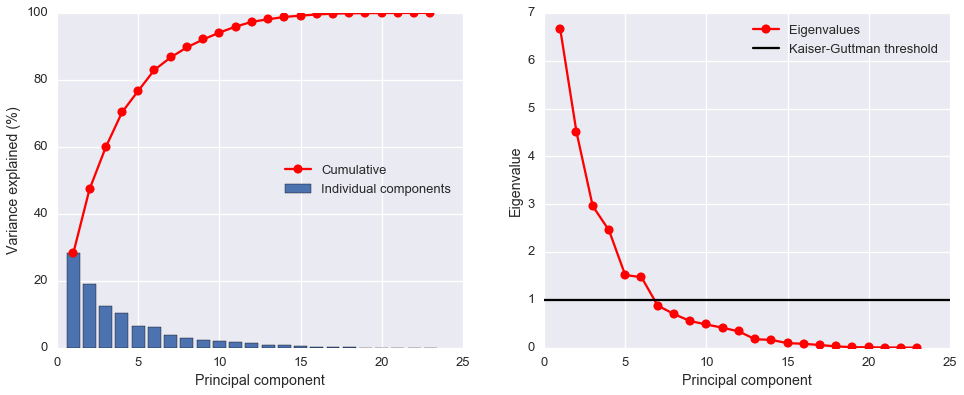

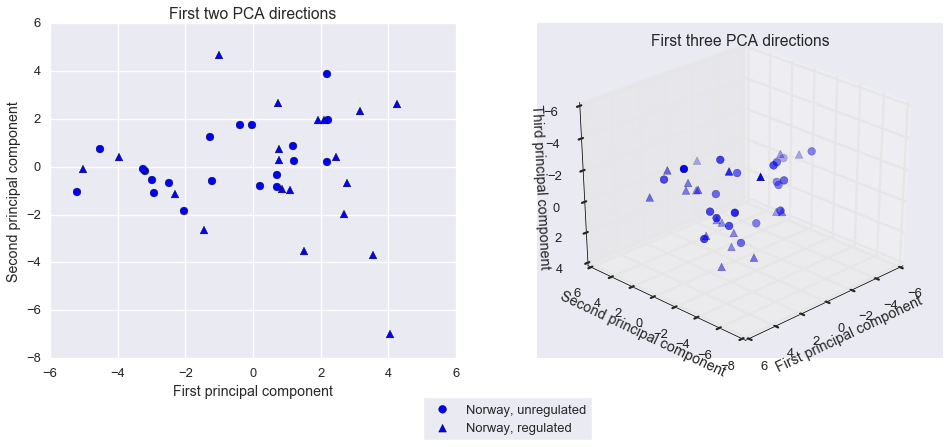

,1,2,3,4,5,6,7,8,9,10,...,14,15,16,17,18,19,20,21,22,23
abund,0.077466,-0.370889,-0.176995,-0.037019,-0.090266,-0.067748,0.088880,-0.228839,-0.280373,0.243098,...,-0.316852,0.153176,-0.268312,0.178901,-0.019095,0.071006,-0.002545,0.110800,-0.064899,-0.055568
n_taxa,0.132154,-0.344479,0.258413,-0.151213,0.132740,-0.145956,0.019273,-0.073737,-0.152895,0.224488,...,0.194034,0.079388,0.205588,-0.012938,-0.063188,0.278754,0.264099,-0.609093,-0.075289,0.137450
ger_sap_idx,-0.079574,-0.006273,-0.051912,0.506744,0.093524,-0.354483,0.049315,0.111271,-0.297284,0.025280,...,-0.340925,-0.474177,0.087848,0.108471,-0.043332,0.064961,0.034104,-0.001376,0.057108,-0.007877
av_score_p_taxon,-0.003133,-0.279696,0.022272,-0.396158,0.249517,-0.049904,0.163241,-0.068178,0.361515,-0.235113,...,-0.258178,-0.550388,-0.159752,-0.135694,0.036591,-0.058981,0.012706,-0.096693,0.066537,0.026935
shan_wei_idx,0.251686,-0.122887,0.372824,0.057992,0.166738,0.072124,-0.128656,-0.181265,-0.002594,-0.079695,...,-0.067484,0.030205,-0.111965,-0.125151,0.047190,0.601967,-0.034700,0.460192,0.131661,-0.094861
even,0.234437,0.074878,0.295350,0.247731,0.129072,0.172251,-0.187907,-0.299062,-0.007027,-0.141481,...,-0.298186,0.101461,-0.330939,0.069229,-0.029290,-0.390840,-0.107306,-0.347997,-0.055985,0.081719
graz_scrap,-0.220185,-0.200111,0.206736,-0.042831,-0.361671,-0.017956,0.134769,0.116715,-0.337730,-0.069188,...,0.272234,-0.261871,-0.311010,-0.016522,-0.222852,-0.108870,0.177230,0.078898,0.057529,0.009605
miners,0.245929,0.241843,-0.061844,-0.288685,0.066103,-0.189850,0.190061,0.052598,-0.155569,-0.066920,...,-0.060766,0.023266,-0.163743,0.100693,0.410802,-0.067725,0.398543,0.162536,-0.469526,-0.009378
xylo,0.075362,-0.085187,0.237468,0.295290,0.255595,-0.308451,0.239389,0.517197,0.164764,-0.091052,...,-0.025398,0.350602,-0.182505,-0.004986,-0.070500,-0.046081,0.064703,0.016124,-0.035359,0.012296
shred,-0.042639,0.022207,0.140647,-0.001385,0.243760,0.644052,0.252471,0.332598,-0.339874,0.022636,...,0.021856,-0.074131,-0.127562,-0.216694,0.117440,-0.017025,-0.027799,-0.041793,0.030666,-0.009856


In [11]:
# Join categorical variables to MZB data
df = mzb_df.join(site_df[['country', 'regulated']])

# Select country
df = df.query('country == "N"')

# Columns to consider
mzb_cols = ['abund', 'n_taxa', 'ger_sap_idx', 'av_score_p_taxon', 
            'shan_wei_idx', 'even', 'graz_scrap', 'miners', 'xylo',
            'shred', 'gath_coll', 'acti_filt_feed', 'pass_filt_feed',
            'pred', 'para', 'swim_skat', 'swim_div', 'burr_bore', 
            'sprawl_walk', 'sessil', 'ept_taxa', 'n_genera', 'life_idx']

# Run PCA
res = ecoreg.run_pca(df, cols=mzb_cols)
res

As above, the results for all metrics are not easy to interpret. This time, the KGC implies keeping 6 PCs, which explain 83% of the variance. 

There is no clear distinction between regulated and unregulated sites on the plots in 2 and 3 dimensions, but there is perhaps a slight tendency for regulated rivers to have larger scores on PC1 and more negative scores on PC2. Based on the loadings table, higher values on PC1 correspond to a greater proportion of sessile species and active filter feeders, but fewer swimmers and divers; more negative scores on PC2 equate to greater overall abundance as well as more taxa and genera. There is therefore a weak suggestion here that regulated sites in Norway have greater abundance and diversity of macroinvertebrates. **This needs investigating in more detail to see if the difference is significant**.

The selected metrics based on the absolute loadings for each of the first seven PCs are given in the table at the end of this section. Unlike the results for Germany, several of the overall metrics already appear in this list. Nevertheless, as a check and for the sake of consistency, it seems worthwhile focusing only on the "overall" metrics, as with Germany (above). 

##### Norway (Overall MZB metrics only)

Variance explained by first 3 PCs (%):

[ 37.75415326  29.06685981  13.44399019]

Total: 80.27%


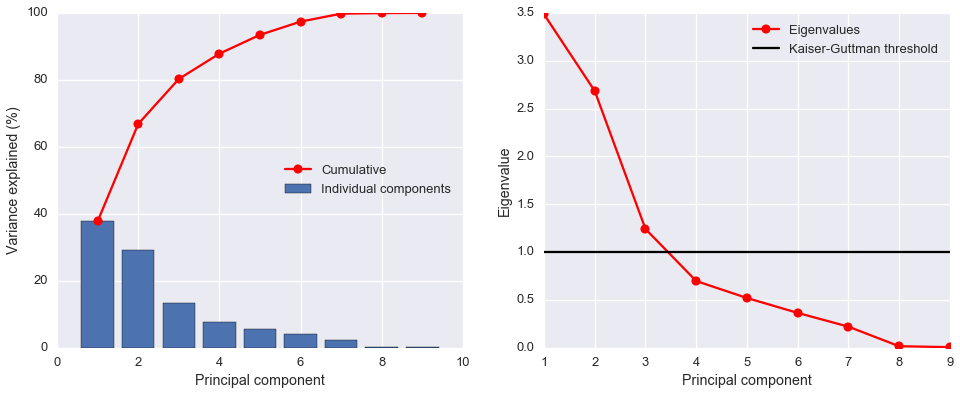

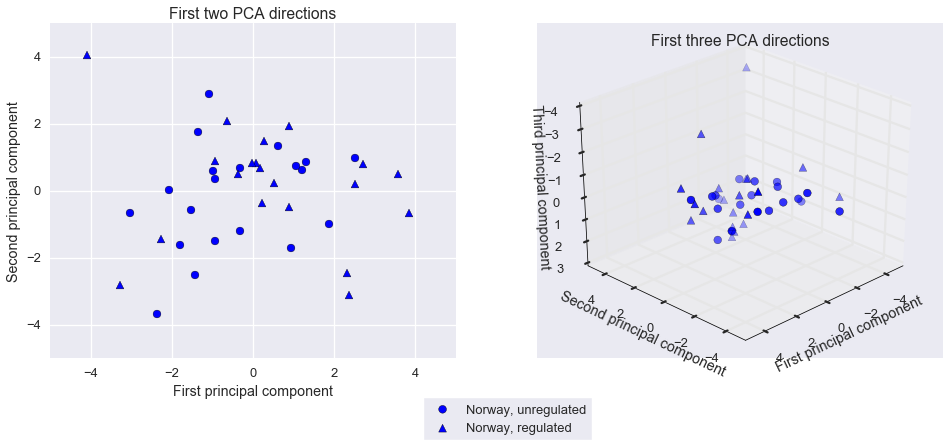

,1,2,3,4,5,6,7,8,9
abund,0.235830,-0.352211,-0.281209,-0.580435,-0.397063,-0.463482,0.163455,-0.025070,-0.067287
n_taxa,0.502155,-0.167226,-0.133344,-0.007866,0.163211,0.115364,-0.354830,-0.183164,0.708967
ger_sap_idx,-0.155209,0.082880,-0.807473,-0.027669,0.361476,0.203543,0.372603,-0.066470,0.030280
av_score_p_taxon,0.280408,-0.417315,0.302324,0.174600,-0.013996,0.309908,0.721531,0.035773,0.084909
shan_wei_idx,0.465562,0.259701,-0.080055,0.304134,-0.099569,-0.097940,0.048184,-0.665991,-0.389266
even,0.252863,0.466792,-0.147644,0.365278,-0.277124,-0.341202,0.230151,0.494115,0.269448
ept_taxa,-0.136221,-0.467686,-0.033614,0.463651,0.396634,-0.622025,-0.036752,-0.016138,-0.027664
n_genera,0.495892,-0.167508,-0.152684,0.017583,0.222722,0.206402,-0.280110,0.521630,-0.509554
life_idx,-0.210604,-0.367196,-0.327229,0.436549,-0.625466,0.280846,-0.229857,-0.008489,-0.013091


In [12]:
# Join categorical variables to MZB data
df = mzb_df.join(site_df[['country', 'regulated']])

# Select country
df = df.query('country == "N"')

# Columns to consider
mzb_cols = ['abund', 'n_taxa', 'ger_sap_idx', 'av_score_p_taxon', 
            'shan_wei_idx', 'even', 'ept_taxa', 'n_genera', 'life_idx']

# Run PCA
res = ecoreg.run_pca(df, cols=mzb_cols)
res

The first 3 PCs explain a little over 80% of the variance, but the projection of the data into the space of the first 2 or 3 PCs does not suggest a clear separation. Perhaps there is a tendency for regulated sites to have higher scores on PC1 and PC3?

PC1 is strongly correlated with the number of taxa, the number of genera and the Shannon-Weiner index - in other words, PC1 seems to be large representative of **diversity**. PC2, meanwhile, has large contributions (but in opposite directions) from **eveness** and **EPT taxa**, but I don't know enough about there metrics to be be able to interpret this. PC3 is overwhelmingly inversely correlated with the German saprobic index.

##### MZB summary

All of the following are very tentative and require further investigation.

 * For sites in Germany, there is a suggestion that regulated rivers may have fewer tax and genera. <br><br>
 
 * In Norway, there is an equally weak suggestion that the opposite is true: regulated sites may have *greater* abundance and diversity.  <br><br>
 
 * Regulated sites in Norway may have a greater proportion of sessile species and active filter feeders, but fewer swimmers and divers. They may also have lower scores on the German saprobic index. <br><br>
 
 * The choices for selected metrics for further analysis for MZB are:
 
| **PC** |  **Germany (all metrics)** | **Germany (overall metrics)** |   **Norway (all metrics)**   | **Norway (overall metrics)** |
|:--:|:----------------------:|:-------------------------:|:------------------------:|:------------------------:|
|  1 |  Active filter feeders |       Number of taxa      |    Swimmers and divers   |      Number of taxa      |
|  2 |        Predators       |         LIFE index        |         Abundance        |         EPT taxa         |
|  3 |       LIFE index       |          EPT taxa         | Shannon-Weiner diversity |   German saprobic index  |
|  4 |  Grazers and scrapers  |                           |   German saprobic index  |                          |
|  5 | Passive filter feeders |                           |   Sprawlers and walkers  |                          |
|  6 |  Burrowers and borers  |                           |         Shredders        |                          |
|  7 |   Swimmers and divers  |                           |                          |                          |

#### 4.2.3. Water chemistry data

##### Overview

We have two sets of chemistry data - one matching the PB sampling and another for the MZB sampling. For Norway, the PB and MZB surveys took place at the same time so the chemistry datasets are identical, but this is not the case in Germany.
We have only 5 chemical variables, so dimensionality reduction may not be necessary, but it is nevertheless worth screening the data here and perhaps looking to see if any variables are redundant. It's also worth checking for outliers.

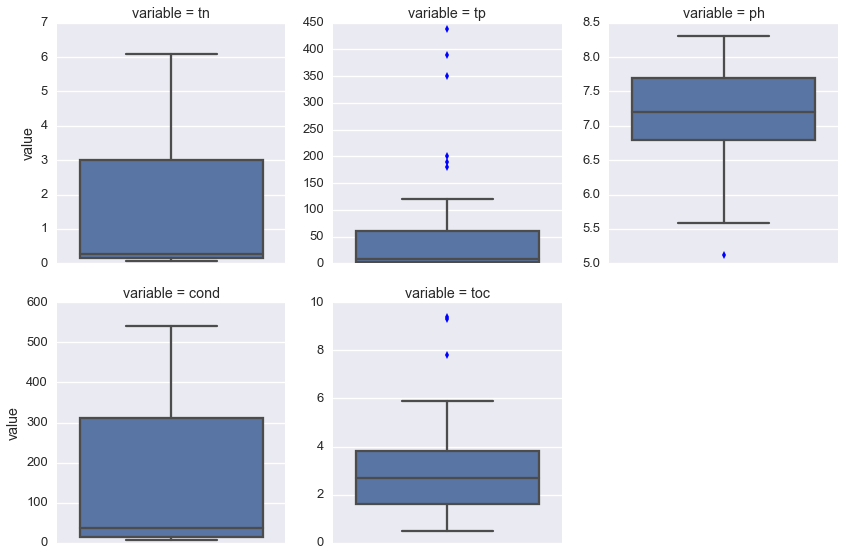

In [13]:
# Columns to consider
chem_cols = ['tn', 'tp', 'ph', 'cond', 'toc']

pb_chem_df = pd.melt(pb_df[chem_cols])

sn.factorplot(y='value', col='variable', data=pb_chem_df,
              kind='box', sharey=False, col_wrap=3)

It looks as though the TP record in particular may include some outliers. There are several German sites with TP concentrations in excess of 100 ug/l, so some of the larger values, despite being high, might be genuine readings. However, the highest recorded concentration of 439 ug/l is actually from a site in Norway, and the next highest concentration recorded for Norwegian site is just 61 ug/l. The TOC and TN values for this outlying record are also fairly low, which suggests the measurement of 439 ug/l may be an error (due to sample contamination?). I will therefore remove it from further consideration in the analysis below.

##### Germany

Variance explained by first 2 PCs (%):

[ 40.32732989  38.79686055]

Total: 79.12%


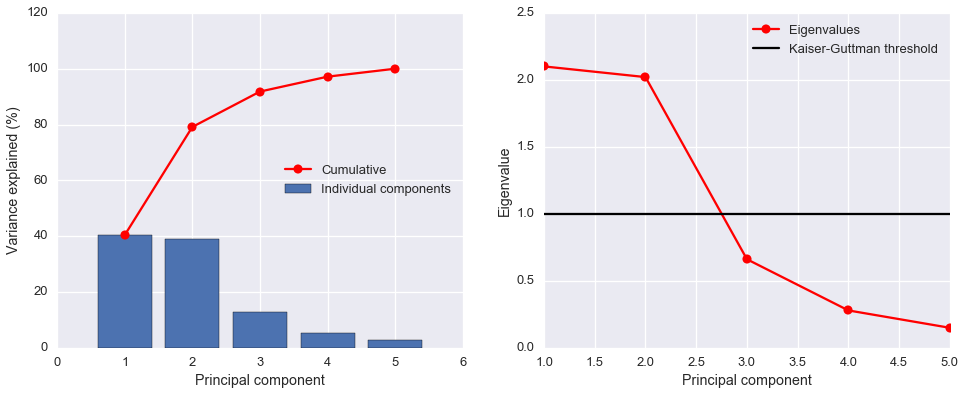

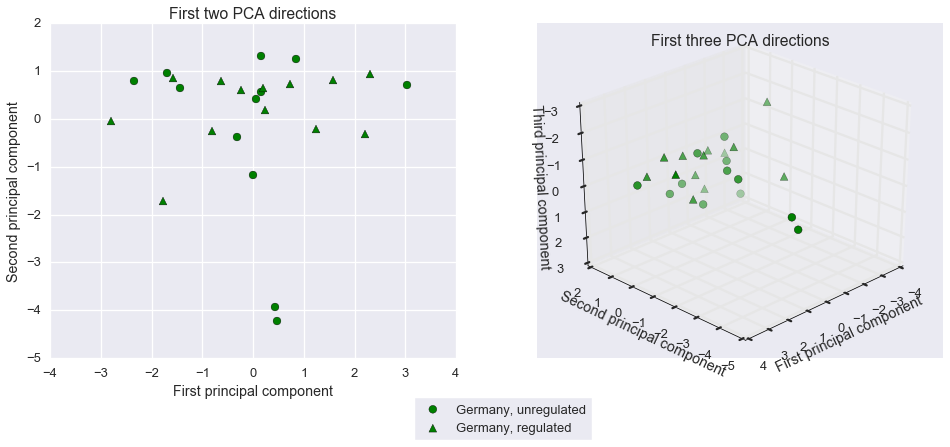

,1,2,3,4,5
tn,0.560129,0.130289,-0.656627,0.466784,0.142246
tp,0.174893,-0.665753,-0.020836,0.162022,-0.706753
ph,0.444585,0.353597,0.702106,0.401690,-0.151679
cond,0.646973,0.021760,0.007361,-0.761356,-0.035155
toc,0.198593,-0.643656,0.274592,0.121834,0.675295


In [14]:
# Join categorical variables to PB data
df = pb_df.join(site_df[['country', 'regulated']])

# Select country
df = df.query('country == "D"')

# Run PCA
res = ecoreg.run_pca(df, cols=chem_cols)
res

The first 2 PCs explain approximately 80% of the variance. PC1 is dominated by **conductivity**, whereas PC2 is inversely correlated with **TP** and **TOC**. There is no obvious distinction between regulated and unregulated sites, but two of the German unregulated rivers are clearly very different to the others: their large negative score on PC2 imply unusually high concentrations of TP and TOC.

##### Norway

Note that the outlier ($TP > 430 \; \mu g/l$) has been removed.

Variance explained by first 3 PCs (%):

[ 38.58174579  31.96264102  19.98102125]

Total: 90.53%


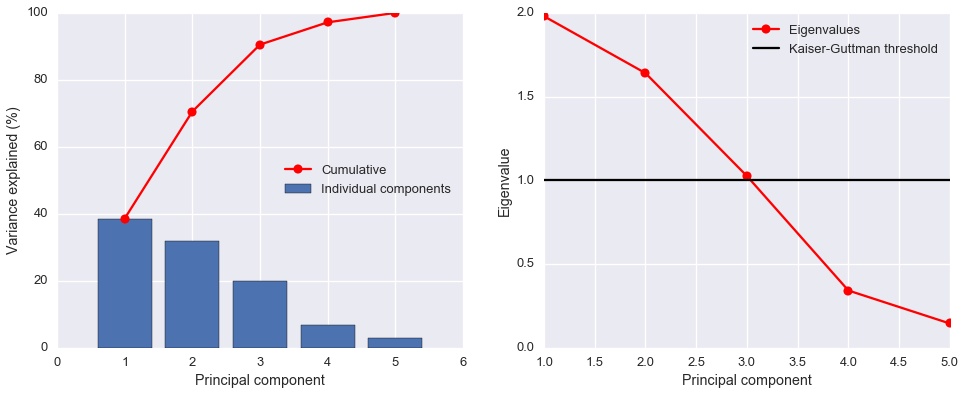

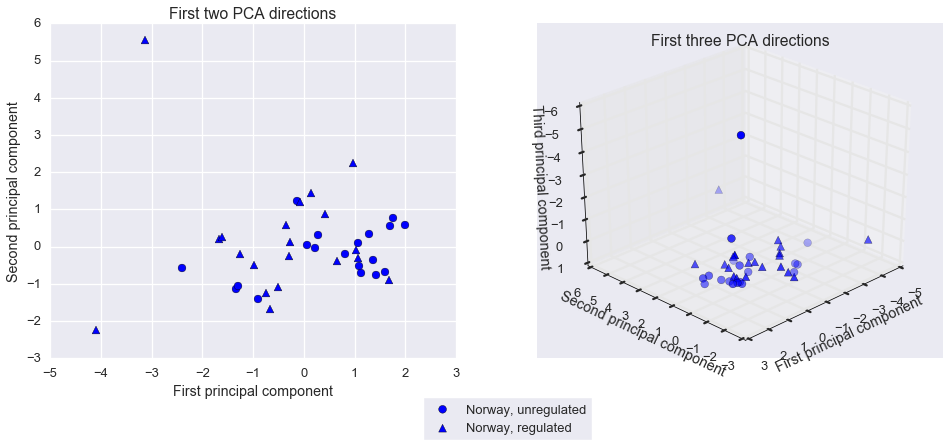

,1,2,3,4,5
tn,-0.661465,0.216671,-0.011237,0.206646,0.687523
tp,0.033848,0.029105,-0.998535,0.030514,-0.002099
ph,0.321633,0.640416,0.009668,-0.630791,0.297369
cond,-0.148437,0.733070,0.030590,0.431849,-0.503135
toc,-0.660179,-0.068423,-0.042104,-0.609898,-0.430968


In [15]:
# Join categorical variables to PB data
df = pb_df.join(site_df[['country', 'regulated']])

# Select country
df = df.query('country == "N"')

# Remove outlier
df = df.query('tp < 430')

# Run PCA
res = ecoreg.run_pca(df, cols=chem_cols)
res

This time the KGC recommends keeping the first three PCs, which explain about 91% of the variance. PC1 is dominated by **TN** and **TOC**, PC2 by **pH** and **conductivity** and PC3 almost entirely comprises **TP**.

There is no clear distinction between regulated versus unregulated locations, but there are some notable outliers, such as the one in the lower-left corner of the 2D plot, which likely corresponds to high TOC concentrations and low pH (i.e. acidification).

##### Water chemistry summary

 * There are no obvious differences in water chemistry between regulated and unregulated sites, either in Norway or Germany. <br><br>
 
 * The selected metrics for further analysis of water chemistry are:
 
| **PC** |    **Germany**   |    **Norway**    |
|:--:|:------------:|:------------:|
|  1 | Conductivity |      TN      |
|  2 |      TP      | Conductivity |
|  3 |              |      TP      |

#### 4.2.4. Hydrological indicators

##### Overview

Some of the main differences in hydrology between Norway and Germany have already been discussed above, and are the main motivation for considering separate analyses in each country. 

The dataset of HIs is fairly complicated: I have calculated 62 indicators based broadly on the IHA methodology of [Richter et al. (1996)](http://onlinelibrary.wiley.com/doi/10.1046/j.1523-1739.1996.10041163.x/abstract), but modified to calculate one set of indices for the entire three year period prior to sampling. Note that, as with water chemistry, the sampling times for PB and MZB at the German sites were not always the same, so there are two slightly different sets of HIs for the German sites - one for PB and one for MZB. However, these metrics are sufficiently similar that the conclusions based on the PB dataset (described below) also apply for MZB. For a full description of the HIs calculated, see [this notebook](http://nbviewer.jupyter.org/github/JamesSample/ECOREG/blob/master/hydro_indicators_diy.ipynb).

##### Germany

**Note:** The code below produces a warning: `ComplexWarning: Casting complex values to real discards the imaginary part`. This appears to be due to very small numerical errors in the solutions for the eigenvalues and eigenvectors from the matrix calculations. The result is that some of the smaller components have very tiny complex parts (e.g. $1.10^{-15}i$). This warning can be ignored.

Variance explained by first 6 PCs (%):

[ 71.84946142  11.84482307   4.0333883    3.20817285   2.13456116
   1.669735  ]

Total: 94.74%


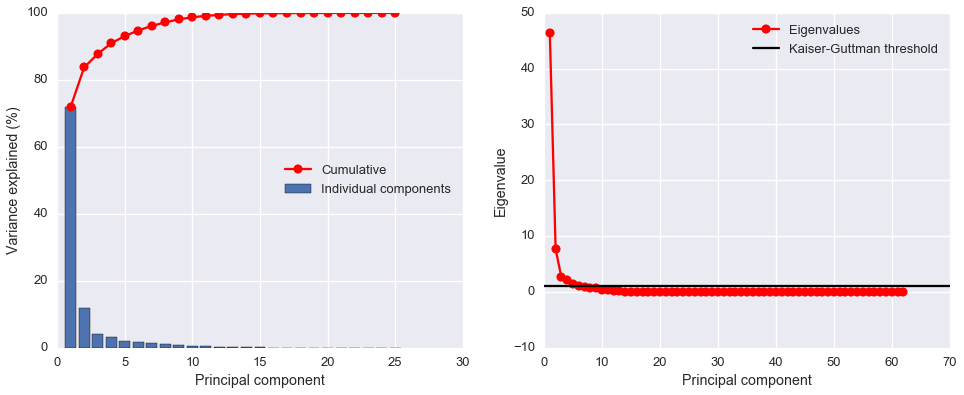

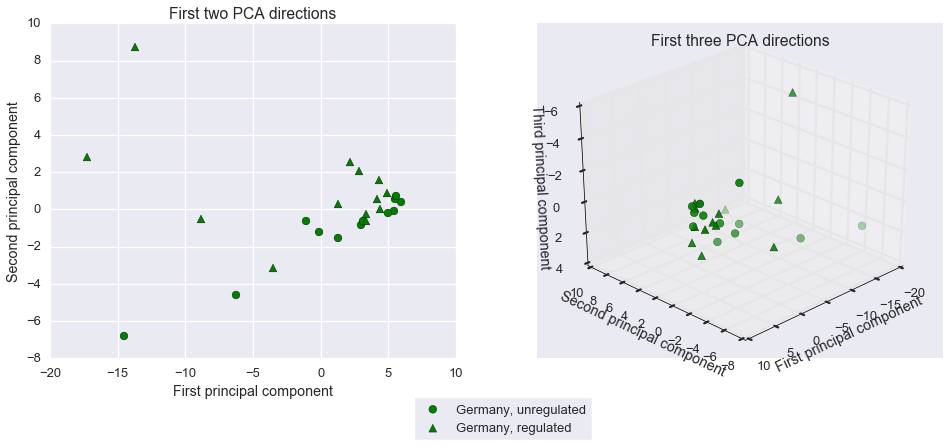

In [16]:
# Join categorical variables to MZB data
df = hi_df.query('(eco_dataset == "pb") and (time_per == 3)')
df = df.join(site_df[['country', 'regulated']])

# Select country
df = df.query('country == "D"')

# Columns to consider
hi_cols = ['mean', 'avg01', 'avg02', 'avg03', 'avg04', 'avg05', 'avg06', 
           'avg07', 'avg08', 'avg09', 'avg10', 'avg11', 'avg12', 
           'min01', 'min02', 'min03', 'min04', 'min05', 'min06', 
           'min07', 'min08', 'min09', 'min10', 'min11', 'min12', 
           'max01', 'max02', 'max03', 'max04', 'max05', 'max06', 
           'max07', 'max08', 'max09', 'max10', 'max11', 'max12', 
           'min', 'p05', 'p25', 'p50', 'p75', 'p95', 'max', 'range', 'iqr',
           'range90', 'cv', 'days_to_max', 'days_to_min', 'days_to_p05', 
           'days_to_p95', 'ma_07_max', 'ma_07_min', 'ma_30_max', 
           'ma_30_min', 'ma_90_max', 'ma_90_min', 'revs_per_yr',
           'n_hi_pulse_yr', 'av_fall_rt', 'av_rise_rt']

# Run PCA
res = ecoreg.run_pca(df, cols=hi_cols)

The fact that the eigenvalues become small and roughly constant after about PC10 implies there is lots of collinearity (and therefore redundancy) between these metrics. The KGC implies keeping just the first 6 PCs, which together explain 95% of the overall variance in the 62-dimensional raw dataset.

The metrics with the highest loading on PC1 are mostly concerned with **average** conditions: the long-term **mean** and **median** flows are prominent, as are the **averages in the summer and autumn** (July to November). PC2, on the other hand, is dominated more by extremes and by metrics describing **flow variability** and **catchment "flashiness"**: **coefficient of variation, range of flows, typical rise rate, maximum summer flow and days before sampling to the last event bigger than the 95th flow percentile**.

##### Norway

Variance explained by first 8 PCs (%):

[ 65.21751362  14.17773608   4.62583254   3.07918883   2.4029621
   1.93276433   1.86976001   1.64948328]

Total: 94.96%


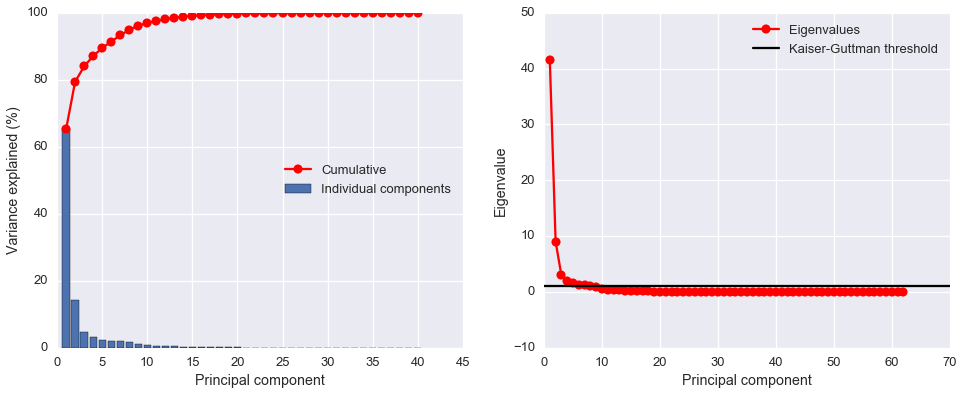

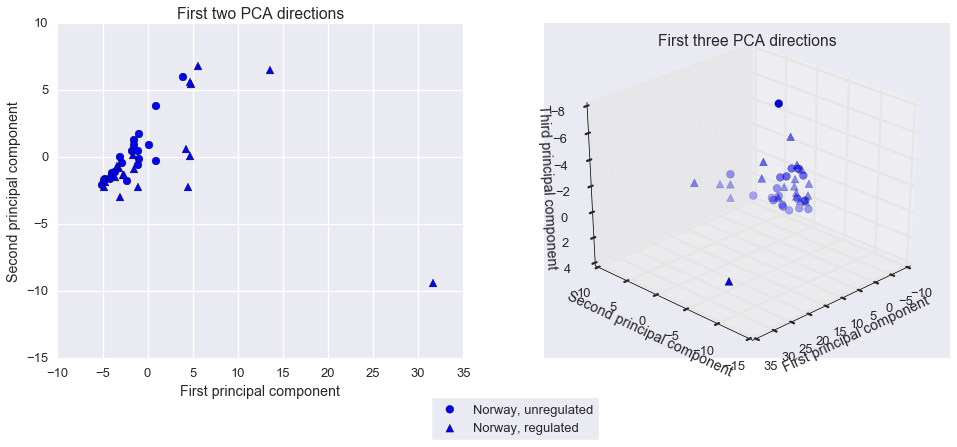

In [17]:
# Join categorical variables to MZB data
df = hi_df.query('(eco_dataset == "pb") and (time_per == 3)')
df = df.join(site_df[['country', 'regulated']])

# Select country
df = df.query('country == "N"')

# Columns to consider
hi_cols = ['mean', 'avg01', 'avg02', 'avg03', 'avg04', 'avg05', 'avg06', 
           'avg07', 'avg08', 'avg09', 'avg10', 'avg11', 'avg12', 
           'min01', 'min02', 'min03', 'min04', 'min05', 'min06', 
           'min07', 'min08', 'min09', 'min10', 'min11', 'min12', 
           'max01', 'max02', 'max03', 'max04', 'max05', 'max06', 
           'max07', 'max08', 'max09', 'max10', 'max11', 'max12', 
           'min', 'p05', 'p25', 'p50', 'p75', 'p95', 'max', 'range', 'iqr',
           'range90', 'cv', 'days_to_max', 'days_to_min', 'days_to_p05', 
           'days_to_p95', 'ma_07_max', 'ma_07_min', 'ma_30_max', 
           'ma_30_min', 'ma_90_max', 'ma_90_min', 'revs_per_yr',
           'n_hi_pulse_yr', 'av_fall_rt', 'av_rise_rt']

# Run PCA
res = ecoreg.run_pca(df, cols=hi_cols)

The first 8 PCs explain around 95% of the variance, although it is clear that the first PC here is being heavily influenced by the outlier visible in the bottom-right of the 2D plot above. This corresponds to Storsjøen (S2.611), which appears to be much larger than any of the other Norwegian stations (the mean discharge here is 102 m3/s for the three years prior to sampling, compared to 61 m3/s for the next largest river in the dataset). Perhaps this site is also more heavily regulated than the others - **check with Susi**? Refitting the PCA with this outlier removed actually makes surprisingly little difference to to results, so I've decided to leave it in for now. 

As with the German data, PC1 in Norway is dominated by metrics representing **average** flow conditions, such as the **mean** and **median** long-term flow and the **average autumn flow** (August to November). The picture is also similar for PC2, where measures of **extremes**, **variability** and **rates of change** are most prominent: the **range**, **long-term maximum**, **spring maximum** (May and June) and the typical **rise rate** are all weighted highly.

Looking at the plots, there is some suggestion that the regulated stations have higher values on the first PC, which broadly corresponds to generally higher flows. This is perhaps unsurprising, as it seems quite likely that the regulated rivers will be larger.

##### Summary of HIs

 * For both Norway and Germany, it is possible to group HIs on the first few PCs according to type: PC1 generally represents average flow conditions, whereas PC2 predominantly reflects flow variability and catchment "flashiness". Such finding are consistent with previous work. For example, [Gao et al. (2009)](http://www.sciencedirect.com/science/article/pii/S0022169409003321) found that:
 
    > *PC1 can be interpreted as being dominated by base flow magnitude and monthly flow; PC2 can be interpreted as being dominated by high flow magnitude; PC3 can be interpreted as monthly flow, rate of change and frequency; etc.*
 
 * The is a suggestion in the Norwegian HI data that regulated rivers are larger than unregulated ones. This can be investigated further, but it probably isn't very interesting. <br><br>
 
 * The selected metrics for further analysis of hydrology are:

| **PC** |          **Germany**         |        **Norway**       |
|:--:|:------------------------:|:-------------------:|
|  1 |           Mean           |         Mean        |
|  2 | Coefficient of variation |        Range        |
|  3 |   Number of high pulses  |   December maximum  |
|  4 |        Days to p05       | Number of reversals |
|  5 |      Days to maximum     |     Days to p95     |
|  6 |      Days to minimum     | Number of reversals |
|  7 |                          |   Days to maximum   |
|  8 |                          |   October maximum   |

#### 4.2.5. Summary of dimensionality reduction

This notebook has produced a lot of plots, most of which aren't especially interesting. However, the original dataset in more than 100 dimensions has been considerably reduced (to around 15 - 20 variables depending on the choices made), and a number of potentially interesting patterns have been identified for subsequent analysis. Points for further investigation are summarised below:

 * Test for differences in PB assemblages between regulated and unregulated sites in Germany. <br><br>

 * For Germany, test whether regulated rivers have fewer MZB tax and genera. <br><br>
 
 * For Norway, test whether regulated sites have *greater* abundance and diversity of MZB (and compare with the results from Germany - see above). <br><br>
 
 * Test whether regulated sites in Norway have a greater proportion of sessile species and active filter feeders, but fewer swimmers and divers. <br><br>
 
 * Test whether regulated sites in Norway have lower scores on the German saprobic index. <br><br>
 
 * Test whether regulated sites in Norway are larger than unregulated ones. Not very interesting, but a useful sense-check of the method. <br><br>
 
The metrics selected for further analysis are:

<img src="https://github.com/JamesSample/ECOREG/blob/master/Images/metrics_selected_pca.png?raw=true" alt="Metrics selected by PCA" width="600">


### This analysis is continued in the [next notebook](http://nbviewer.jupyter.org/github/JamesSample/ECOREG/blob/master/ecoreg_full_analysis_2.ipynb).